In [30]:
import os
import json
import numpy             as np
import matplotlib.pyplot as plt
import sympy             as sp
import pandas            as pd
import re

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections     import defaultdict
from scipy.stats     import pearsonr  
from collections     import defaultdict
import seaborn as sns

In [18]:
def resultados(modelo):
    pasta_resultado = os.path.join("results", modelo)  
    
    y_test = []
    y_pred = []

    for i in range(1, 100):
        filename = f"result_run_{i}.json"
        filepath = os.path.join(pasta_resultado, filename)

        if os.path.exists(filepath):
            with open(filepath, "r") as file:
                data = json.load(file)

                y_test.append(np.array(data["y_test"]))
                y_pred.append(np.array(data["y_pred"]))

    return y_test, y_pred

In [19]:
def listar_modelos():
    pasta_principal = "results"
    
    # Verifica se a pasta existe
    if not os.path.exists(pasta_principal):
        print("A pasta 'results' não existe.")
        return []
    
    # Lista apenas os diretórios dentro da pasta 'results'
    pastas = [nome for nome in os.listdir(pasta_principal) if os.path.isdir(os.path.join(pasta_principal, nome))]
    
    return pastas

In [20]:
def calculate_metrics(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    
    R     = np.corrcoef(y_test, y_pred)[0, 1]  # Correlation Coefficient (R)
    R2    = r2_score(y_test, y_pred)          # R² Score
    RMSE  = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
    MAE   = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
    MAPE  = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error
    
    return R, R2, RMSE, MAE, MAPE

In [21]:
# Função para percorrer as pastas e arquivos JSON
def process_results(base_dir):
    # Criar um DataFrame vazio para armazenar os resultados
    columns = ['Model', 'Run', 'Seed', 'R', 'R2', 'RMSE', 'MAE', 'MAPE']
    df_results = pd.DataFrame(columns=columns)

    # Percorrer as pastas dentro de base_dir
    for model_dir in os.listdir(base_dir):
        model_path = os.path.join(base_dir, model_dir)
        
        # Verificar se é um diretório
        if os.path.isdir(model_path):
            for json_file in os.listdir(model_path):
                if json_file.endswith('.json'):
                    json_path = os.path.join(model_path, json_file)
                    
                    # Abrir o arquivo JSON
                    with open(json_path, 'r') as file:
                        data = json.load(file)
                        
                        # Extrair as informações necessárias
                        run    = data.get('run')
                        seed   = data.get('seed')
                        model  = data.get('Model')
                        y_test = data.get('y_test')
                        y_pred = data.get('y_pred')
                        
                        # Calcular as métricas
                        R, R2, RMSE, MAE, MAPE = calculate_metrics(y_test, y_pred)
                        
                        # Criar um DataFrame com a linha de resultados
                        result_df = pd.DataFrame([{
                            'Model': model,
                            'Run'  : run,
                            'Seed' : seed,
                            'R'    : R,
                            'R2'   : R2,
                            'RMSE' : RMSE,
                            'MAE'  : MAE,
                            'MAPE' : MAPE
                        }])
                        
                        # Concatenar a linha ao DataFrame principal
                        df_results = pd.concat([df_results, result_df], ignore_index=True)
    
    return df_results

In [22]:
# Caminho para a pasta 'results'
base_dir = './results'

# Processar os resultados
df_metrics = process_results(base_dir)

# Agrupar por modelo e calcular médias e desvios padrões
df_metrics = df_metrics.groupby('Model').agg(
    {'R'   : ['mean', 'std'],
     'R2'  : ['mean', 'std'],
     'RMSE': ['mean', 'std'],
     'MAE' : ['mean', 'std'],
     'MAPE': ['mean', 'std']}).reset_index()

# Renomear as colunas para o formato desejado (ex: 'R_mean', 'R_std', etc.)
df_metrics.columns = [
    'Model',
    'R'    , 'R_std', 
    'R2'   , 'R2_std', 
    'RMSE' , 'RMSE_std',
    'MAE'  , 'MAE_std',
    'MAPE' , 'MAPE_std'
]

In [23]:
df_metrics.to_latex("model_performance.tex", index=False, float_format="%.4f")

/tmp/ipykernel_15129/3595543358.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_metrics.to_latex("model_performance.tex", index=False, float_format="%.4f")


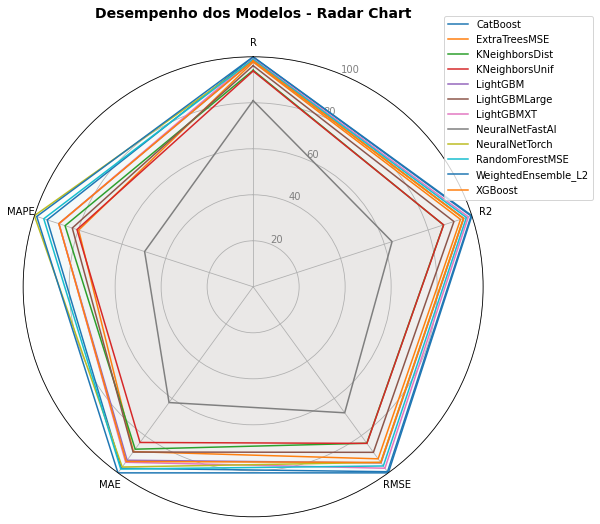

In [24]:
# Filtrar as colunas necessárias
metrics=[
        'R', 
        #'WI',
        'R2', 
        #'RRMSE',
        #'RMSELKX', 'RMSELQ', 
        #'RMSE$(K_x<100)$', 'RMSE$(B/H<50)$', 
        'RMSE', #'NDEI', 
        'MAE', #'Accuracy', 
        'MAPE',
        #'NSE', #'LNSE', 
        #'KGE',
        #'MARE', 
        #'MSE',
        #'VAF', 'MAE (MJ/m$^2$)', 'R',  'RMSE (MJ/m$^2$)',
        ]
    
metrics_max =  ['NSE', 'VAF', 'R', 'Accuracy','R2', 'KGE', 'WI'] 
df = df_metrics[metrics]

# Normalizar os dados (inverter RMSE, MAE e MAPE para melhor visualização no radar)
normalized_data = df.copy()
for metric in metrics:
    if metric in metrics_max:
        normalized_data[metric] = (normalized_data[metric] / normalized_data[metric].max())
    else:
        normalized_data[metric] = (normalized_data[metric].min() / normalized_data[metric])

# Preparar os dados para o gráfico
labels = metrics
num_vars = len(labels)

# Adicionar o primeiro elemento ao final para fechar o gráfico
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Criar o gráfico de radar
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for i, row in normalized_data.iterrows():
    values = row.tolist()
    values += values[:1]  # Fechar o gráfico
    ax.plot(angles, values, label=df_metrics['Model'][i])
    ax.fill(angles, values, alpha=0.01)

# Configurar os eixos
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["20", "40", "60", "80", "100"], color="gray", size=10)
ax.set_ylim(0, 1)

# Legenda e título
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1), fontsize=10)  # Ajuste do posicionamento
plt.title("Desempenho dos Modelos - Radar Chart", size=14, weight="bold", pad=20)

# Ajustar o layout para evitar que a legenda seja cortada
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Ajuste o retângulo da figura para acomodar a legenda
plt.savefig('plots/Radar Chart.png', dpi=300, bbox_inches='tight')  # Evita cortes ao salvar
plt.show()

In [25]:
def plot_resultados(modelo):
    y_test, y_pred = resultados(modelo)

    #metricas de avaliaçao
    mae  = []
    rmse = []
    r    = []
    r2   = []
    mape = []
    for i in range(len(y_test)):
        mae.append(mean_absolute_error(y_test[i], y_pred[i]))
        rmse.append(np.sqrt(mean_squared_error(y_test[i], y_pred[i])))
        r.append(np.corrcoef(y_test[i], y_pred[i])[0, 1])
        r2.append(r2_score(y_test[i], y_pred[i]))
        mape.append(np.mean(np.abs((y_test[i] - y_pred[i]) / y_test[i])))

    r_mean =  np.mean(r)
    r_std     = np.std(r)
    
    r2_mean   = np.mean(r2)
    r2_std    = np.std(r2)
    
    rmse_mean = np.mean(rmse)
    rmse_std  = np.std(rmse)
    
    mape_mean = np.mean(mape)*100
    mape_std  = np.std(mape)*100

    # Transformando listas de arrays em arrays únicos para análise
    y_test = np.concatenate(y_test) if y_test else np.array([])
    y_pred = np.concatenate(y_pred) if y_pred else np.array([])

    if y_test.size == 0 or y_pred.size == 0:
        print("Nenhum dado encontrado para plotagem.")
        return

    

    # Ordenar y_test e y_pred para facilitar a visualização
    sorted_indices = np.argsort(y_test)
    y_test_sorted = y_test[sorted_indices]
    y_pred_sorted = y_pred[sorted_indices]

    # Agrupar os valores para calcular média e desvio padrão
    unique_y_test = np.unique(y_test_sorted)
    mean_y_pred = np.array([np.mean(y_pred_sorted[y_test_sorted == y]) for y in unique_y_test])
    std_y_pred = np.array([np.std(y_pred_sorted[y_test_sorted == y]) for y in unique_y_test])


    # Criando gráfico com barras de erro
    plt.figure(figsize=(8, 6))
    plt.errorbar(unique_y_test, mean_y_pred, yerr=std_y_pred, fmt='o', capsize=5, mfc='#0979b0', mec='black', label="Média ± Desvio Padrão")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', label="Linha Ideal", color='#0979b0')

    plt.text(0.95, 0.15, f'R = {r_mean:.2f} $\\pm $ {r_std:.2f} \n$R^2$ = {r2_mean:.2f} $\\pm $ {r2_std:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         horizontalalignment='right',  # Alinha o texto à direita
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))


    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Preditos")
    #plt.title(f"{modelo}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'plots/{modelo}.png', dpi = 300)
    plt.show()


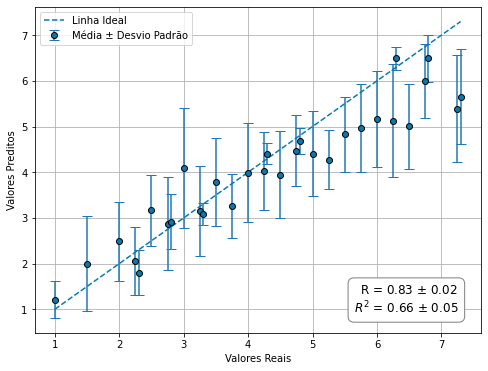

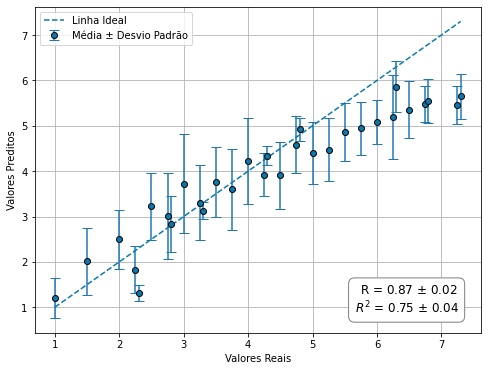

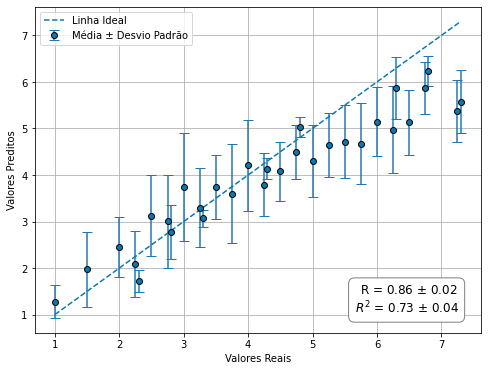

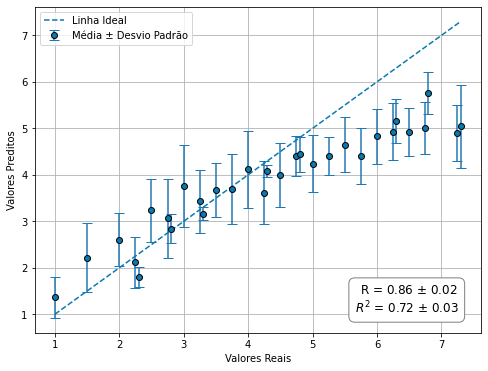

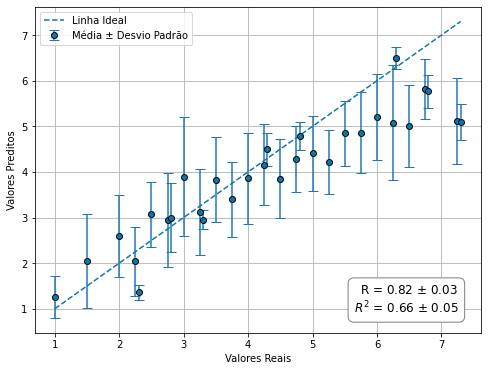

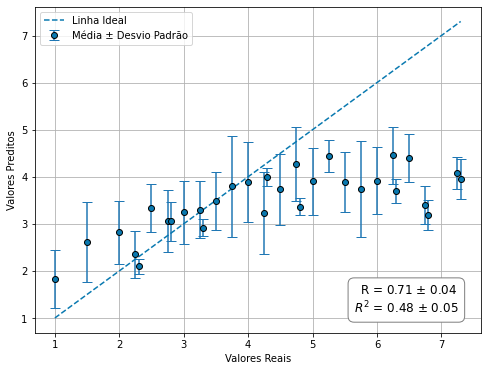

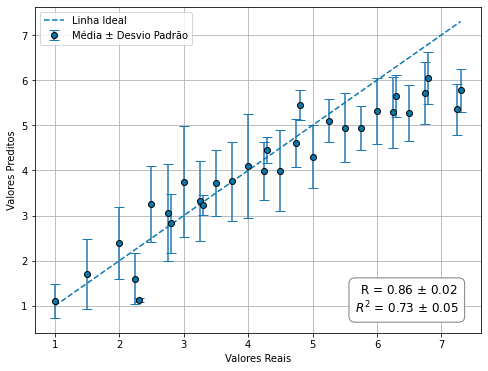

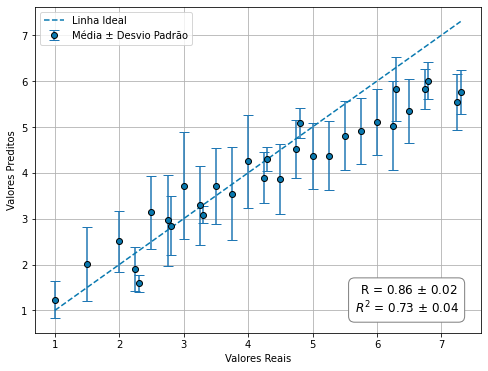

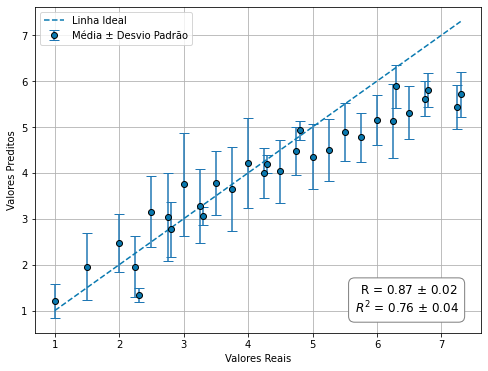

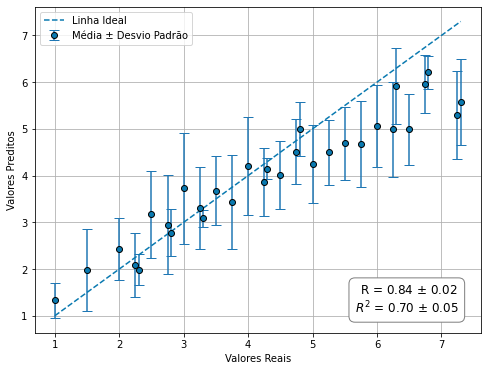

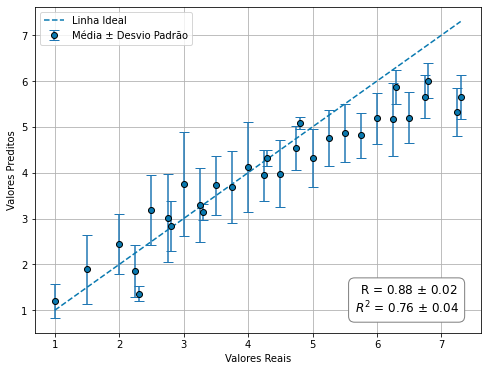

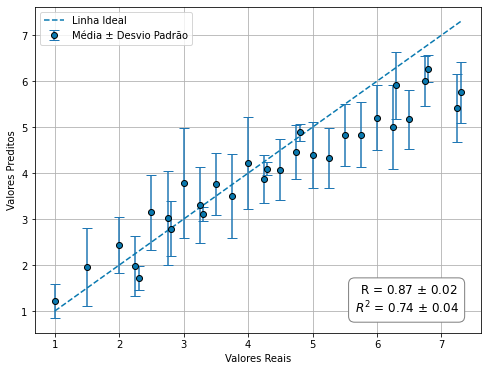

In [26]:
modelos = listar_modelos()

for modelo in modelos:
    plot_resultados(modelo)

In [27]:
process_results(base_dir)

,Model,Run,Seed,R,R2,RMSE,MAE,MAPE
0,KNeighborsDist,47,160,0.825166,0.674099,0.974505,0.682804,25.686579
1,KNeighborsDist,55,100,0.768966,0.565975,1.110541,0.764323,28.342508
2,KNeighborsDist,93,390,0.807026,0.637370,1.097260,0.741871,26.131701
3,KNeighborsDist,3,26,0.848039,0.715221,0.965939,0.634853,23.021825
4,KNeighborsDist,84,678,0.814914,0.647592,1.064127,0.783502,26.887039
...,...,...,...,...,...,...,...,...
1195,RandomForestMSE,41,826,0.843826,0.705589,0.918433,0.627174,23.091931
1196,RandomForestMSE,97,855,0.838607,0.658432,0.906322,0.650147,24.481932
1197,RandomForestMSE,20,96,0.900937,0.809900,0.750793,0.558049,21.212682
1198,RandomForestMSE,12,759,0.891389,0.791546,0.820458,0.636000,25.371414


In [28]:
def feature_importance_analysis(modelo, save_plots=True):
    """ 
    Lê os arquivos da pasta results/{modelo}, analisa as importâncias das features e gera gráficos. 
    """
    pasta_resultado = os.path.join("results", modelo)  
    feature_importance_data = []

    for i in range(1, 100):  # Ajuste conforme o número de execuções
        filename = f"result_run_{i}.json"
        filepath = os.path.join(pasta_resultado, filename)

        if os.path.exists(filepath):
            with open(filepath, "r", encoding="utf-8") as file:
                data = json.load(file)

                # Captura as importâncias das features
                if "Feature importance" in data:
                    for feature, valores in data["Feature importance"].items():
                        feature_importance_data.append({
                            "Feature": feature,
                            "Importance": valores["importance"],
                            "StdDev": valores["stddev"],
                            "P_Value": valores["p_value"],
                            "N": valores["n"],
                            "P99_High": valores["p99_high"],
                            "P99_Low": valores["p99_low"],
                            "Normalized_Importance": valores["normalized_importance"]
                        })

    # Criar DataFrame e calcular estatísticas
    df_importance = pd.DataFrame(feature_importance_data)
    
    if df_importance.empty:
        print("Nenhum dado encontrado!")
        return None  

    df_summary = df_importance.groupby("Feature").agg(
        Mean_Importance=("Importance", "mean"),
        StdDev_Mean=("StdDev", "mean"),
        P_Value_Mean=("P_Value", "mean"),
        N_Samples=("N", "sum"),
        P99_High_Mean=("P99_High", "mean"),
        P99_Low_Mean=("P99_Low", "mean"),
        Normalized_Importance_Mean=("Normalized_Importance", "mean")
    ).reset_index()

    # Criar pasta para salvar gráficos
    if save_plots:
        os.makedirs("feature_importance_plots", exist_ok=True)

    # Gráfico de barras das importâncias médias
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_summary, x="Mean_Importance", y="Feature", palette="viridis")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Importância Média das Features - {modelo}")
    if save_plots:
        plt.savefig(f"feature_importance_plots/{modelo}_barplot.png")
    plt.show()

    # Boxplot das importâncias
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_importance, x="Importance", y="Feature", palette="coolwarm")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(f"Distribuição das Importâncias - {modelo}")
    if save_plots:
        plt.savefig(f"feature_importance_plots/{modelo}_boxplot.png")
    plt.show()

    # Distribuição das importâncias normalizadas
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df_importance, x="Normalized_Importance", hue="Feature", fill=True, common_norm=False)
    plt.xlabel("Importance")
    plt.title(f"Distribuição das Importâncias Normalizadas - {modelo}")
    if save_plots:
        plt.savefig(f"feature_importance_plots/{modelo}_kdeplot.png")
    plt.show()

    return None


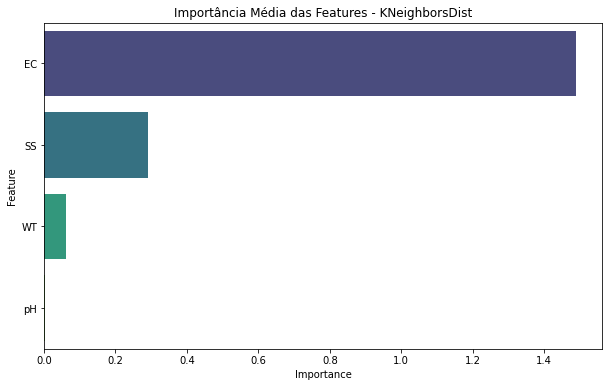

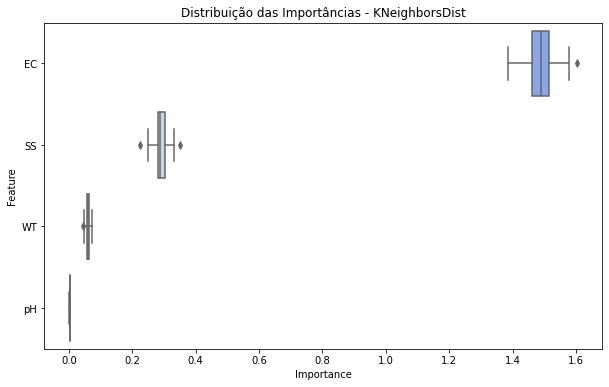

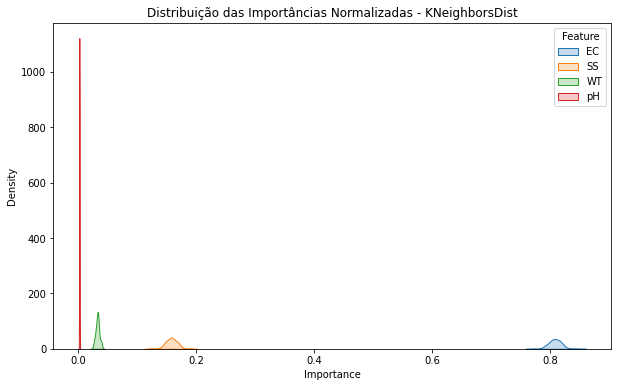

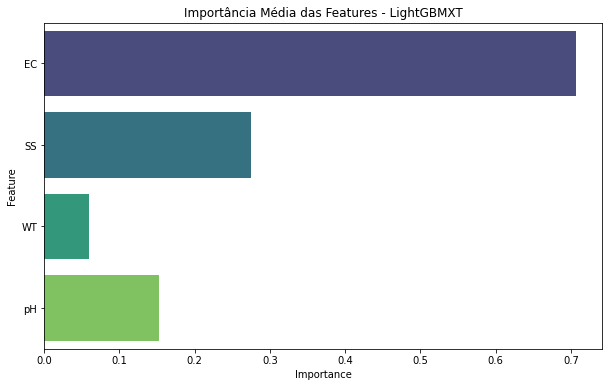

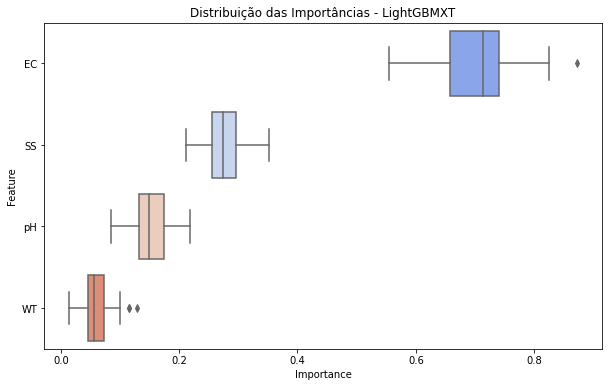

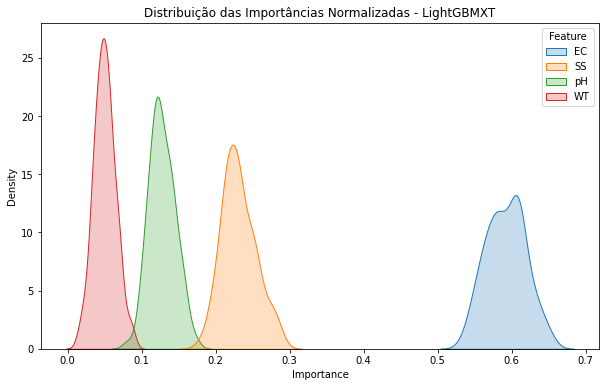

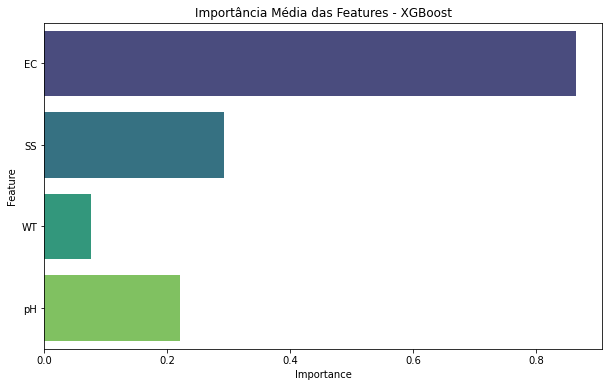

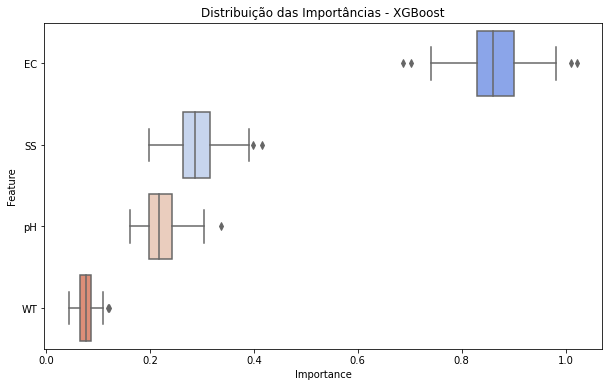

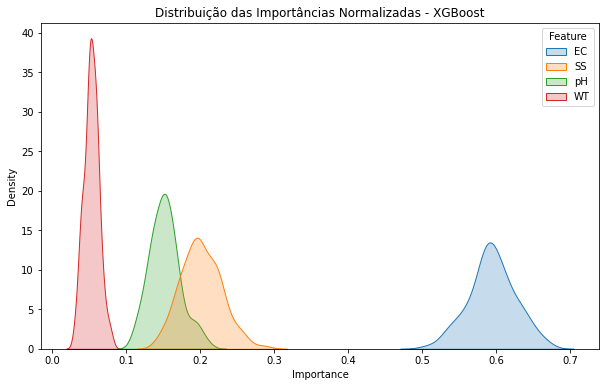

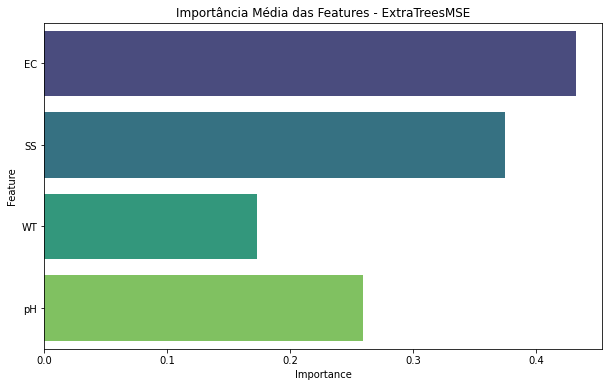

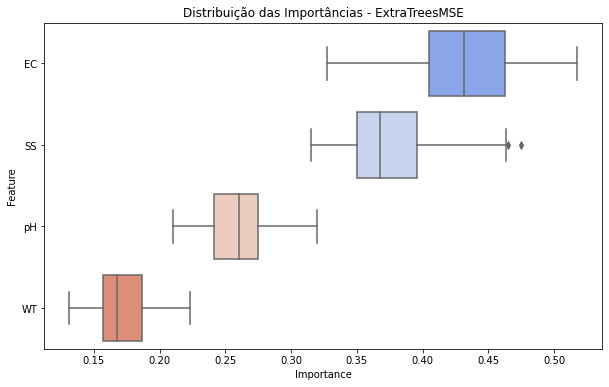

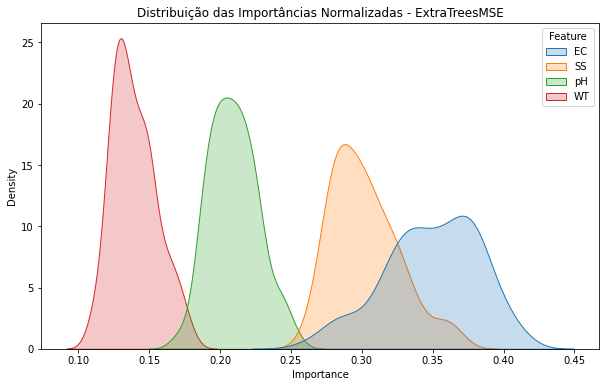

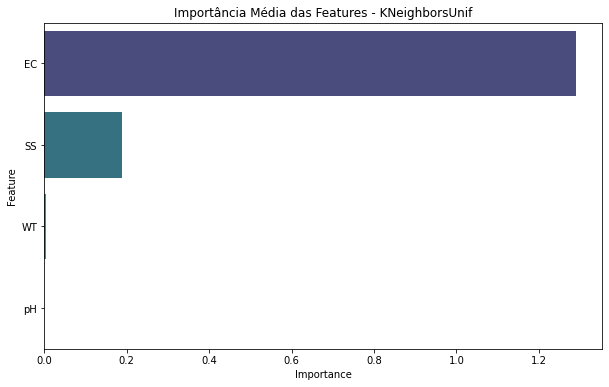

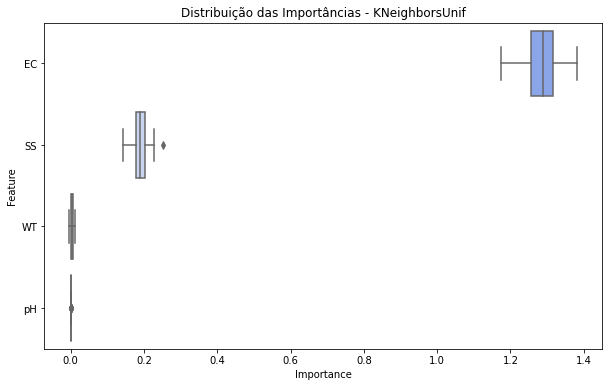

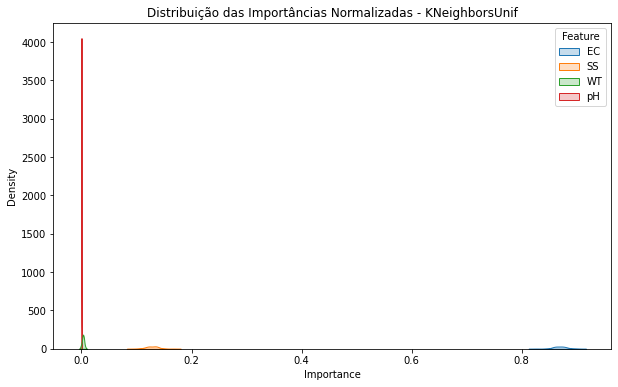

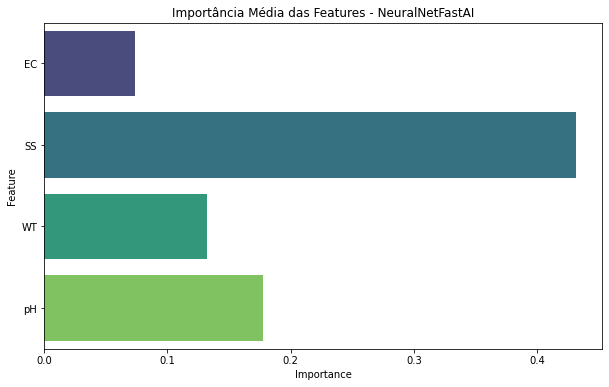

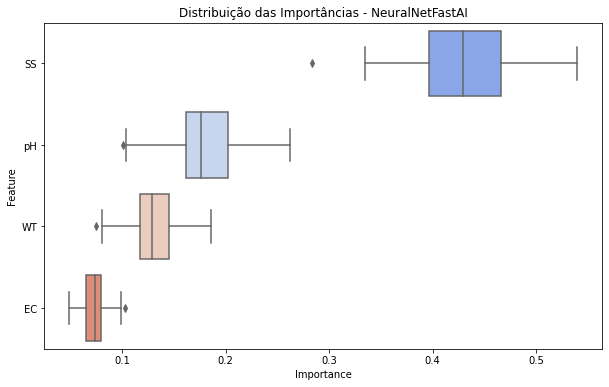

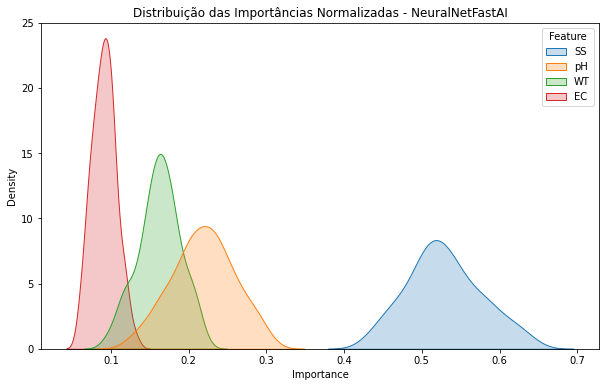

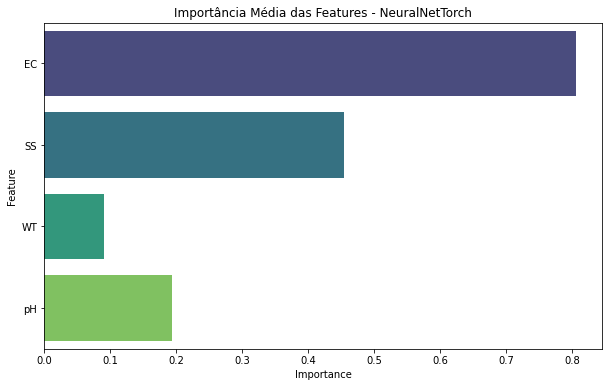

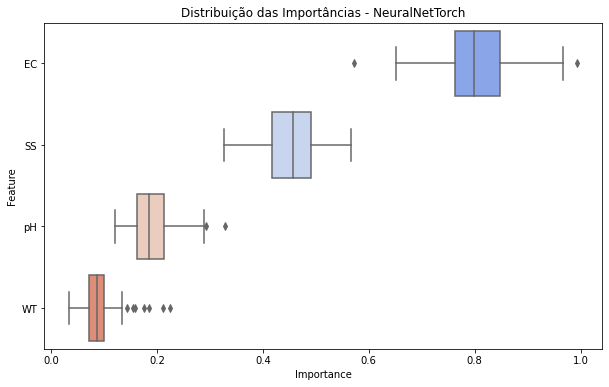

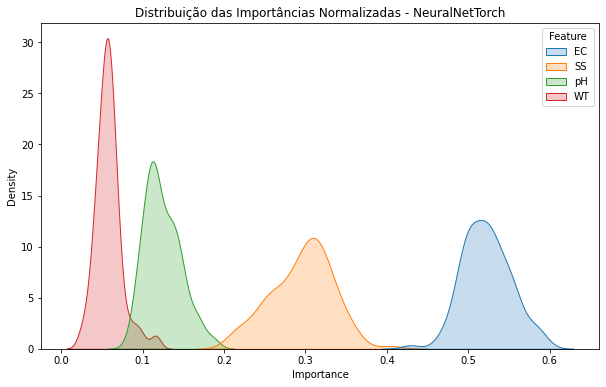

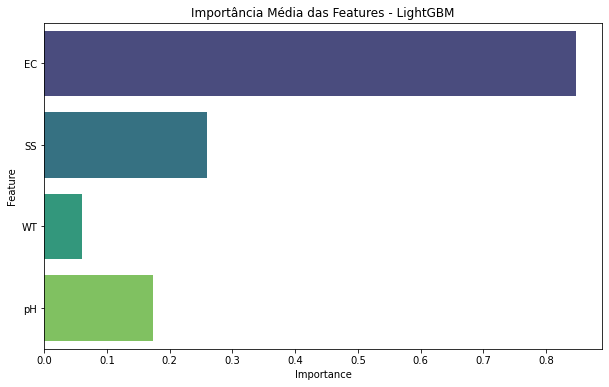

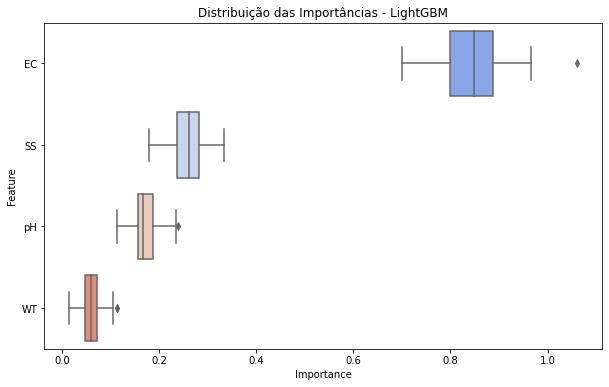

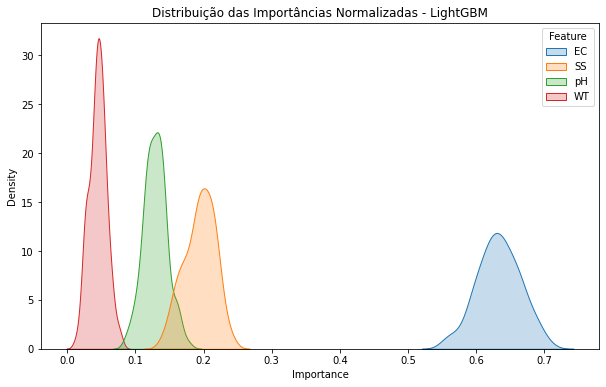

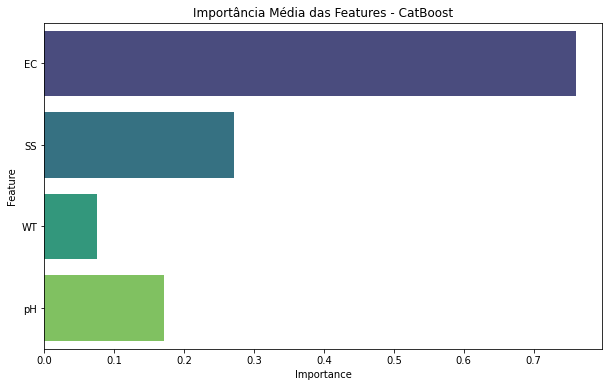

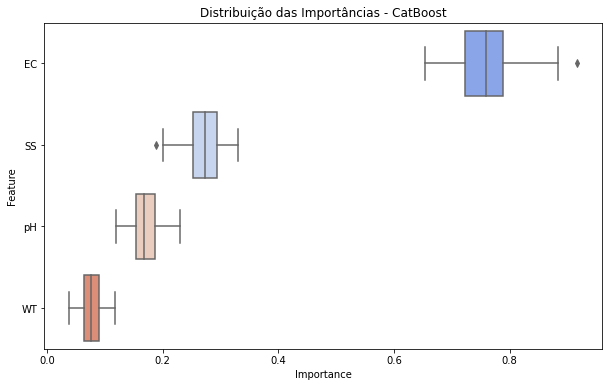

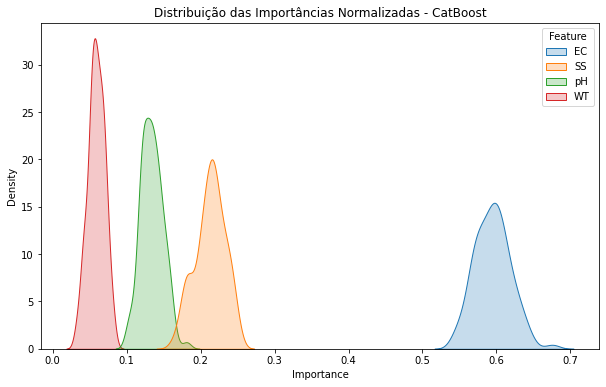

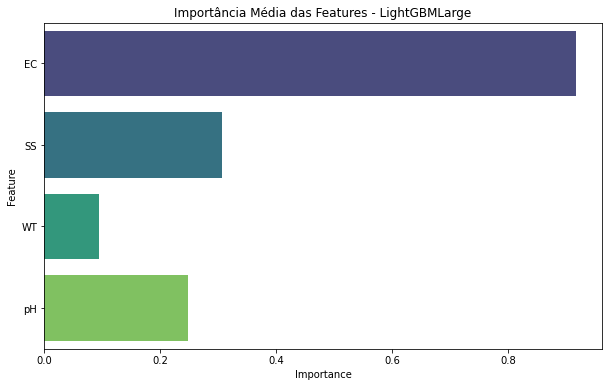

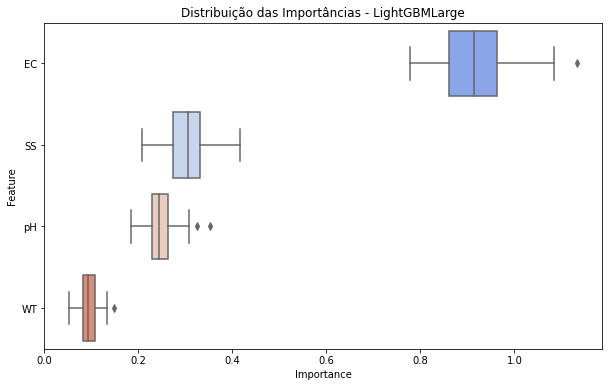

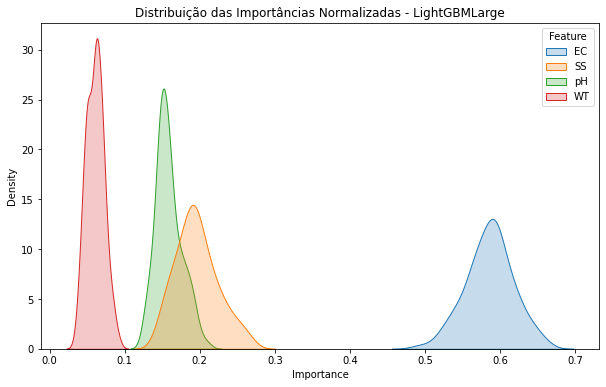

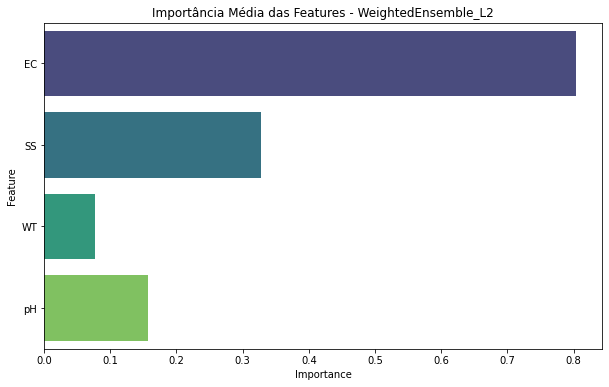

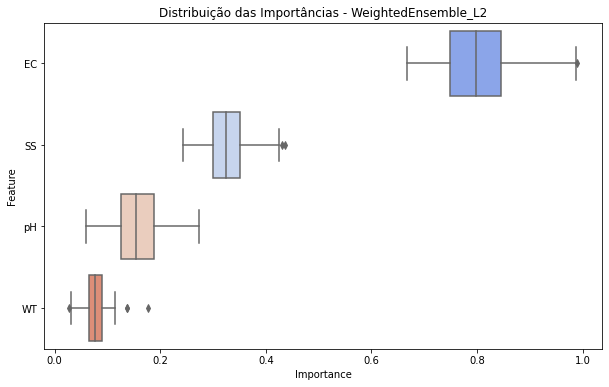

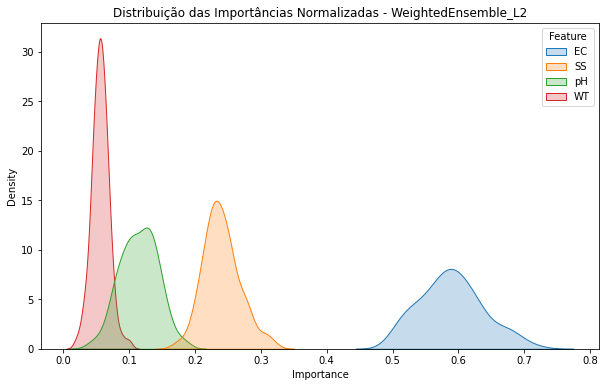

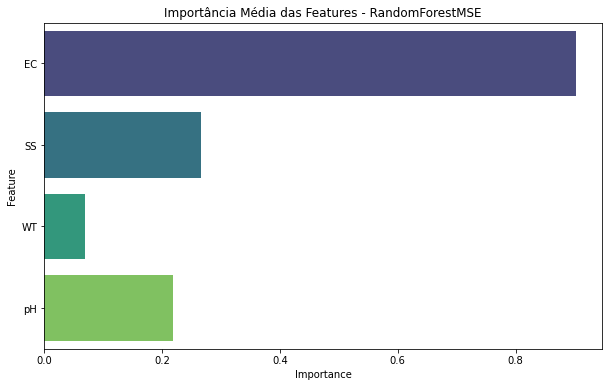

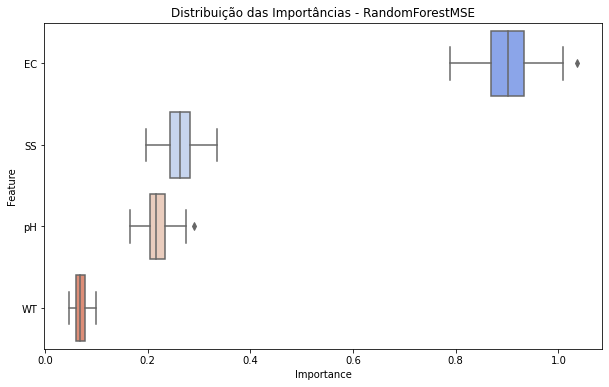

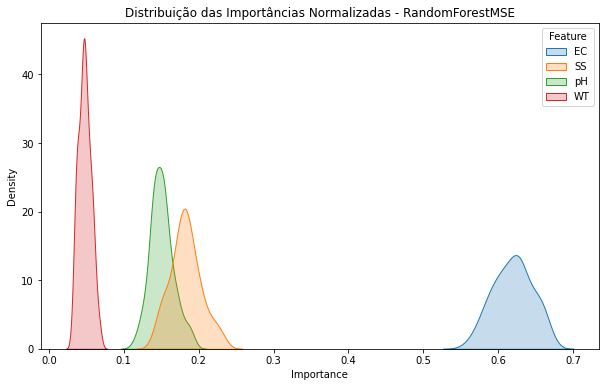

In [31]:
for modelo in modelos:
    feature_importance_analysis(modelo)

# Code for statistical analysis

In [39]:
from scipy.stats import anderson, kstest, norm
import numpy as np

def process_results(base_dir):
    # Criar um DataFrame vazio para armazenar os resultados
    columns = ['Model', 'Run', 'Seed', 'R', 'R2', 'RMSE', 'MAE', 'MAPE', 
               'AD_Statistic', 'AD_Critical_5pct', 'AD_Normal', 
               'KS_Statistic', 'KS_pvalue', 'KS_Normal']
    df_results = pd.DataFrame(columns=columns)

    # Percorrer as pastas dentro de base_dir
    for model_dir in os.listdir(base_dir):
        model_path = os.path.join(base_dir, model_dir)
        
        # Verificar se é um diretório
        if os.path.isdir(model_path):
            for json_file in os.listdir(model_path):
                if json_file.endswith('.json'):
                    json_path = os.path.join(model_path, json_file)
                    
                    # Abrir o arquivo JSON
                    with open(json_path, 'r') as file:
                        data = json.load(file)
                        
                        # Extrair as informações necessárias
                        run    = data.get('run')
                        seed   = data.get('seed')
                        model  = data.get('Model')
                        y_test = np.array(data.get('y_test'))
                        y_pred = np.array(data.get('y_pred'))
                        
                        # Calcular as métricas
                        R, R2, RMSE, MAE, MAPE = calculate_metrics(y_test, y_pred)
                        
                        # Calcular resíduos
                        residuals = y_pred - y_test
                        
                        # Teste de normalidade - Anderson-Darling
                        ad_result = anderson(residuals)
                        ad_statistic = ad_result.statistic
                        ad_critical_5pct = ad_result.critical_values[2]  # 5% significance level
                        ad_normal = bool(ad_statistic < ad_critical_5pct)  # Explicit cast to bool
                        
                        # Teste de normalidade - Kolmogorov-Smirnov
                        # Primeiro, normalizar os resíduos para teste KS
                        residuals_normalized = (residuals - np.mean(residuals)) / np.std(residuals)
                        ks_statistic, ks_pvalue = kstest(residuals_normalized, 'norm')
                        ks_normal = bool(ks_pvalue > 0.05)  # Explicit cast to bool
                        
                        # Criar um DataFrame com a linha de resultados
                        result_df = pd.DataFrame([{
                            'Model': model,
                            'Run': run,
                            'Seed': seed,
                            'R': R,
                            'R2': R2,
                            'RMSE': RMSE,
                            'MAE': MAE,
                            'MAPE': MAPE,
                            'AD_Statistic': ad_statistic,
                            'AD_Critical_5pct': ad_critical_5pct,
                            'AD_Normal': ad_normal,
                            'KS_Statistic': ks_statistic,
                            'KS_pvalue': ks_pvalue,
                            'KS_Normal': ks_normal
                        }])
                        
                        # Concatenar a linha ao DataFrame principal
                        df_results = pd.concat([df_results, result_df], ignore_index=True)
    
    # Ensure boolean columns have proper dtype
    bool_columns = ['AD_Normal', 'KS_Normal']
    for col in bool_columns:
        df_results[col] = df_results[col].astype(bool)
    
    return df_results

# Optional: Function to print summary of normality tests
def print_normality_summary(df_results):
    """Print a summary of normality test results by model"""
    print("Normality Test Results Summary:")
    print("=" * 50)
    
    models = df_results['Model'].unique()
    for model in models:
        model_data = df_results[df_results['Model'] == model]
        
        ad_normal_count = model_data['AD_Normal'].sum()
        ks_normal_count = model_data['KS_Normal'].sum()
        total_runs = len(model_data)
        
        print(f"\nModel: {model}")
        print(f"Total runs: {total_runs}")
        print(f"Anderson-Darling: {ad_normal_count}/{total_runs} normal distributions ({ad_normal_count/total_runs*100:.1f}%)")
        print(f"Kolmogorov-Smirnov: {ks_normal_count}/{total_runs} normal distributions ({ks_normal_count/total_runs*100:.1f}%)")
        
        # Print average test statistics
        print(f"Avg AD Statistic: {model_data['AD_Statistic'].mean():.3f}")
        print(f"Avg KS p-value: {model_data['KS_pvalue'].mean():.3f}")

# Alternative version with explicit dtype specification during concat
def process_results_v2(base_dir):
    """Alternative version that avoids the warning by using explicit dtypes"""
    results_list = []  # Use list instead of incremental DataFrame
    
    # Percorrer as pastas dentro de base_dir
    for model_dir in os.listdir(base_dir):
        model_path = os.path.join(base_dir, model_dir)
        
        # Verificar se é um diretório
        if os.path.isdir(model_path):
            for json_file in os.listdir(model_path):
                if json_file.endswith('.json'):
                    json_path = os.path.join(model_path, json_file)
                    
                    # Abrir o arquivo JSON
                    with open(json_path, 'r') as file:
                        data = json.load(file)
                        
                        # Extrair as informações necessárias
                        run    = data.get('run')
                        seed   = data.get('seed')
                        model  = data.get('Model')
                        y_test = np.array(data.get('y_test'))
                        y_pred = np.array(data.get('y_pred'))
                        
                        # Calcular as métricas
                        R, R2, RMSE, MAE, MAPE = calculate_metrics(y_test, y_pred)
                        
                        # Calcular resíduos
                        residuals = y_pred - y_test
                        
                        # Teste de normalidade - Anderson-Darling
                        ad_result = anderson(residuals)
                        ad_statistic = ad_result.statistic
                        ad_critical_5pct = ad_result.critical_values[2]
                        ad_normal = ad_statistic < ad_critical_5pct
                        
                        # Teste de normalidade - Kolmogorov-Smirnov
                        residuals_normalized = (residuals - np.mean(residuals)) / np.std(residuals)
                        ks_statistic, ks_pvalue = kstest(residuals_normalized, 'norm')
                        ks_normal = ks_pvalue > 0.05
                        
                        # Append to list instead of concat
                        results_list.append({
                            'Model': model,
                            'Run': run,
                            'Seed': seed,
                            'R': R,
                            'R2': R2,
                            'RMSE': RMSE,
                            'MAE': MAE,
                            'MAPE': MAPE,
                            'AD_Statistic': ad_statistic,
                            'AD_Critical_5pct': ad_critical_5pct,
                            'AD_Normal': ad_normal,
                            'KS_Statistic': ks_statistic,
                            'KS_pvalue': ks_pvalue,
                            'KS_Normal': ks_normal
                        })
    
    # Create DataFrame once at the end with explicit dtypes
    df_results = pd.DataFrame(results_list)
    
    # Ensure boolean columns have proper dtype
    bool_columns = ['AD_Normal', 'KS_Normal']
    for col in bool_columns:
        df_results[col] = df_results[col].astype(bool)
    
    return df_results

In [40]:

# Optional: Function to print summary of normality tests
def print_normality_summary(df_results):
    """Print a summary of normality test results by model"""
    print("Normality Test Results Summary:")
    print("=" * 50)
    
    models = df_results['Model'].unique()
    for model in models:
        model_data = df_results[df_results['Model'] == model]
        
        ad_normal_count = model_data['AD_Normal'].sum()
        ks_normal_count = model_data['KS_Normal'].sum()
        total_runs = len(model_data)
        
        print(f"\nModel: {model}")
        print(f"Total runs: {total_runs}")
        print(f"Anderson-Darling: {ad_normal_count}/{total_runs} normal distributions ({ad_normal_count/total_runs*100:.1f}%)")
        print(f"Kolmogorov-Smirnov: {ks_normal_count}/{total_runs} normal distributions ({ks_normal_count/total_runs*100:.1f}%)")
        
        # Print average test statistics
        print(f"Avg AD Statistic: {model_data['AD_Statistic'].mean():.3f}")
        print(f"Avg KS p-value: {model_data['KS_pvalue'].mean():.3f}")


In [42]:

# Example usage:
df_results = process_results_v2(base_dir)
df_results

,Model,Run,Seed,R,R2,RMSE,MAE,MAPE,AD_Statistic,AD_Critical_5pct,AD_Normal,KS_Statistic,KS_pvalue,KS_Normal
0,KNeighborsDist,47,160,0.825166,0.674099,0.974505,0.682804,25.686579,1.881742,0.765,False,0.107440,0.082222,True
1,KNeighborsDist,55,100,0.768966,0.565975,1.110541,0.764323,28.342508,2.275545,0.765,False,0.122042,0.032820,False
2,KNeighborsDist,93,390,0.807026,0.637370,1.097260,0.741871,26.131701,2.667047,0.765,False,0.116135,0.048264,False
3,KNeighborsDist,3,26,0.848039,0.715221,0.965939,0.634853,23.021825,3.601150,0.765,False,0.167786,0.000862,False
4,KNeighborsDist,84,678,0.814914,0.647592,1.064127,0.783502,26.887039,0.848613,0.765,False,0.088595,0.226084,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,RandomForestMSE,41,826,0.843826,0.705589,0.918433,0.627174,23.091931,3.129932,0.765,False,0.116501,0.047151,False
1196,RandomForestMSE,97,855,0.838607,0.658432,0.906322,0.650147,24.481932,1.652723,0.765,False,0.116965,0.045770,False
1197,RandomForestMSE,20,96,0.900937,0.809900,0.750793,0.558049,21.212682,1.690900,0.765,False,0.146960,0.005220,False
1198,RandomForestMSE,12,759,0.891389,0.791546,0.820458,0.636000,25.371414,0.621821,0.765,True,0.102073,0.111892,True


In [44]:
print_normality_summary(df_results)

Normality Test Results Summary:

Model: KNeighborsDist
Total runs: 100
Anderson-Darling: 0/100 normal distributions (0.0%)
Kolmogorov-Smirnov: 20/100 normal distributions (20.0%)
Avg AD Statistic: 2.801
Avg KS p-value: 0.024

Model: LightGBMXT
Total runs: 100
Anderson-Darling: 24/100 normal distributions (24.0%)
Kolmogorov-Smirnov: 86/100 normal distributions (86.0%)
Avg AD Statistic: 1.315
Avg KS p-value: 0.286

Model: XGBoost
Total runs: 100
Anderson-Darling: 0/100 normal distributions (0.0%)
Kolmogorov-Smirnov: 49/100 normal distributions (49.0%)
Avg AD Statistic: 2.386
Avg KS p-value: 0.081

Model: ExtraTreesMSE
Total runs: 100
Anderson-Darling: 2/100 normal distributions (2.0%)
Kolmogorov-Smirnov: 62/100 normal distributions (62.0%)
Avg AD Statistic: 1.805
Avg KS p-value: 0.109

Model: KNeighborsUnif
Total runs: 100
Anderson-Darling: 4/100 normal distributions (4.0%)
Kolmogorov-Smirnov: 54/100 normal distributions (54.0%)
Avg AD Statistic: 1.882
Avg KS p-value: 0.093

Model: Neura

In [45]:
import pandas as pd
import numpy as np

def create_paper_table(df_results, decimal_places=3):
    """
    Create a summary table for academic papers from the results DataFrame.
    
    Parameters:
    -----------
    df_results : pd.DataFrame
        DataFrame containing model results with metrics and normality tests
    decimal_places : int
        Number of decimal places to display (default: 3)
    
    Returns:
    --------
    pd.DataFrame : Summary table formatted for academic papers
    """
    
    # Define the metrics to include in the table
    metrics = ['R2', 'RMSE', 'MAE', 'MAPE', 'AD_Statistic', 'KS_pvalue']
    metric_names = ['R²', 'RMSE', 'MAE', 'MAPE (%)', 'AD Statistic', 'KS p-value']
    
    # Create summary statistics for each model
    summary_data = []
    
    for model in df_results['Model'].unique():
        model_data = df_results[df_results['Model'] == model]
        
        model_summary = {'Model': model}
        
        # Calculate mean ± std for each metric
        for metric, display_name in zip(metrics, metric_names):
            if metric == 'MAPE':
                # Convert MAPE to percentage
                mean_val = model_data[metric].mean() * 100
                std_val = model_data[metric].std() * 100
            else:
                mean_val = model_data[metric].mean()
                std_val = model_data[metric].std()
            
            # Format as "mean ± std"
            if metric in ['AD_Statistic', 'KS_pvalue']:
                formatted_value = f"{mean_val:.{decimal_places}f} ± {std_val:.{decimal_places}f}"
            else:
                formatted_value = f"{mean_val:.{decimal_places}f} ± {std_val:.{decimal_places}f}"
            
            model_summary[display_name] = formatted_value
        
        # Add normality test results (count of normal distributions)
        total_runs = len(model_data)
        ad_normal_count = model_data['AD_Normal'].sum()
        ks_normal_count = model_data['KS_Normal'].sum()
        
        model_summary['AD Normal (%)'] = f"{ad_normal_count}/{total_runs} ({ad_normal_count/total_runs*100:.1f}%)"
        model_summary['KS Normal (%)'] = f"{ks_normal_count}/{total_runs} ({ks_normal_count/total_runs*100:.1f}%)"
        
        # Add sample size
        model_summary['N'] = total_runs
        
        summary_data.append(model_summary)
    
    # Create DataFrame and set Model as index for better presentation
    paper_table = pd.DataFrame(summary_data)
    paper_table = paper_table.set_index('Model')
    
    return paper_table

def create_detailed_statistical_table(df_results, decimal_places=3):
    """
    Create a more detailed statistical table with confidence intervals.
    
    Parameters:
    -----------
    df_results : pd.DataFrame
        DataFrame containing model results
    decimal_places : int
        Number of decimal places to display
    
    Returns:
    --------
    pd.DataFrame : Detailed statistical table
    """
    
    metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
    metric_names = ['R²', 'RMSE', 'MAE', 'MAPE (%)']
    
    detailed_data = []
    
    for model in df_results['Model'].unique():
        model_data = df_results[df_results['Model'] == model]
        
        model_details = {'Model': model}
        
        for metric, display_name in zip(metrics, metric_names):
            values = model_data[metric].values
            if metric == 'MAPE':
                values = values * 100  # Convert to percentage
            
            mean_val = np.mean(values)
            std_val = np.std(values, ddof=1)
            sem_val = std_val / np.sqrt(len(values))  # Standard error of the mean
            ci_low = mean_val - 1.96 * sem_val  # 95% CI lower bound
            ci_high = mean_val + 1.96 * sem_val  # 95% CI upper bound
            
            # Format with confidence interval
            if metric == 'MAPE':
                formatted_value = f"{mean_val:.{decimal_places}f} [{ci_low:.{decimal_places}f}, {ci_high:.{decimal_places}f}]"
            else:
                formatted_value = f"{mean_val:.{decimal_places}f} [{ci_low:.{decimal_places}f}, {ci_high:.{decimal_places}f}]"
            
            model_details[display_name] = formatted_value
        
        # Add normality test summary
        ad_normal_pct = model_data['AD_Normal'].mean() * 100
        ks_normal_pct = model_data['KS_Normal'].mean() * 100
        
        model_details['AD Normal %'] = f"{ad_normal_pct:.1f}%"
        model_details['KS Normal %'] = f"{ks_normal_pct:.1f}%"
        model_details['Runs'] = len(model_data)
        
        detailed_data.append(model_details)
    
    detailed_table = pd.DataFrame(detailed_data)
    detailed_table = detailed_table.set_index('Model')
    
    return detailed_table

def create_best_performance_table(df_results, decimal_places=3):
    """
    Create a table highlighting the best performing model for each metric.
    
    Parameters:
    -----------
    df_results : pd.DataFrame
        DataFrame containing model results
    decimal_places : int
        Number of decimal places to display
    
    Returns:
    --------
    pd.DataFrame : Table with best performers highlighted
    """
    
    # Group by model and calculate mean performance
    mean_performance = df_results.groupby('Model').mean(numeric_only=True)
    
    # For metrics where higher is better
    higher_better = ['R2', 'R']
    # For metrics where lower is better
    lower_better = ['RMSE', 'MAE', 'MAPE', 'AD_Statistic']
    
    best_performers = {}
    
    for metric in higher_better + lower_better:
        if metric in mean_performance.columns:
            if metric in higher_better:
                best_model = mean_performance[metric].idxmax()
                best_value = mean_performance[metric].max()
            else:
                best_model = mean_performance[metric].idxmin()
                best_value = mean_performance[metric].min()
            
            if metric == 'MAPE':
                best_value = best_value * 100  # Convert to percentage
            
            best_performers[metric] = {
                'Best Model': best_model,
                'Best Value': f"{best_value:.{decimal_places}f}"
            }
    
    best_table = pd.DataFrame(best_performers).T
    return best_table

def export_tables_to_latex(df_results, filename=None):
    """
    Export the results tables to LaTeX format for direct inclusion in papers.
    
    Parameters:
    -----------
    df_results : pd.DataFrame
        DataFrame containing model results
    filename : str, optional
        If provided, saves LaTeX code to file
    """
    
    paper_table = create_paper_table(df_results)
    
    latex_code = paper_table.to_latex(
        caption="Performance comparison of machine learning models with normality test results for residuals",
        label="tab:model_comparison",
        position='h!',
        escape=False,
        multirow=True
    )
    
    if filename:
        with open(filename, 'w') as f:
            f.write(latex_code)
        print(f"LaTeX table saved to {filename}")
    
    return latex_code

# Example usage and demonstration
def demonstrate_tables(df_results):
    """
    Demonstrate all table creation functions.
    """
    print("MAIN RESULTS TABLE FOR PAPER")
    print("=" * 60)
    main_table = create_paper_table(df_results)
    print(main_table)
    print("\n")
    
    print("DETAILED STATISTICAL TABLE WITH CONFIDENCE INTERVALS")
    print("=" * 60)
    detailed_table = create_detailed_statistical_table(df_results)
    print(detailed_table)
    print("\n")
    
    print("BEST PERFORMING MODELS BY METRIC")
    print("=" * 60)
    best_table = create_best_performance_table(df_results)
    print(best_table)
    print("\n")
    
    return main_table, detailed_table, best_table



In [47]:
# Usage example:
main_table, detailed_table, best_table = demonstrate_tables(df_results)


MAIN RESULTS TABLE FOR PAPER
                                R²           RMSE            MAE  \
Model                                                              
KNeighborsDist       0.663 ± 0.054  1.009 ± 0.076  0.688 ± 0.055   
LightGBMXT           0.750 ± 0.037  0.870 ± 0.064  0.637 ± 0.047   
XGBoost              0.733 ± 0.040  0.899 ± 0.073  0.639 ± 0.052   
ExtraTreesMSE        0.723 ± 0.031  0.918 ± 0.055  0.678 ± 0.044   
KNeighborsUnif       0.664 ± 0.055  1.008 ± 0.078  0.718 ± 0.055   
NeuralNetFastAI      0.484 ± 0.048  1.253 ± 0.078  0.965 ± 0.060   
NeuralNetTorch       0.733 ± 0.046  0.899 ± 0.079  0.620 ± 0.053   
LightGBM             0.734 ± 0.045  0.897 ± 0.076  0.644 ± 0.050   
CatBoost             0.759 ± 0.036  0.854 ± 0.068  0.616 ± 0.048   
LightGBMLarge        0.700 ± 0.046  0.954 ± 0.077  0.676 ± 0.057   
WeightedEnsemble_L2  0.762 ± 0.037  0.849 ± 0.069  0.600 ± 0.048   
RandomForestMSE      0.743 ± 0.043  0.881 ± 0.074  0.613 ± 0.050   

                  

In [48]:

# To get LaTeX code:
latex_code = export_tables_to_latex(df_results, "model_results_table.tex")

LaTeX table saved to model_results_table.tex


/tmp/ipykernel_15129/508362932.py:189: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = paper_table.to_latex(
